# Perform Feature Selection for GAM Model
## Setup Jupyter Notebook

In [0]:
!pip install pygam

### Import packages

In [0]:
# Import external packages
import pandas as pd
import os
import numpy as np
import random 
import pyarrow.parquet as pq
import sys
import shutil
import pickle
import warnings
from itertools import chain

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error

from pygam import GAM, s, te, f, l, utils

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import optuna
from optuna.visualization import matplotlib as optunampl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 260)
warnings.filterwarnings("ignore")

In [0]:
# Import the internal package
package_loc = r""

# Add the package location to system paths
sys.path.append(package_loc)

from src import utility
from src.gam import training, explain

### Define Paths

In [0]:
###########################################################################
###########################################################################

product = "DB"
model_type = "GAM"
path = f"{product}"
model_version = "v3"

###########################################################################
###########################################################################

# Define the directories for input and output
dir_input = f"{path}/Input"
dir_data = f"{path}/{model_type}/Export"
dir_output = (
    f"{path}/{model_type}/Output"
    if model_version == ""
    else f"{path}/{model_type}/Output/{model_version}"
)

print(os.listdir(dir_input))
print(os.listdir(dir_data))
print(os.listdir(dir_output))

['CMI Numerical Bands.xlsx', 'CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb']
['CMI DB Categorical Bands (with CalendarYear).xlsx', 'CMI DB Categorical Bands.xlsx', 'db_gam_modelling_data.parquet', 'db_gam_modelling_data_v2.parquet']
['02_model_note_db_gam_v3.xlsx', 'db_gam_initial_v3.pkl']


## Create Modelling Data

In [0]:
###########################################################################
###########################################################################

data_version = "v2"
model_data_file = f"db_gam_modelling_data_{data_version}.parquet"

###########################################################################
###########################################################################

model_data = pd.read_parquet(f"{dir_data}/{model_data_file}")
model_data

In [0]:
###########################################################################
###########################################################################

claim_count = "IncurredClaims"
claim_freq = "AnnualFreq"
weight = "LivesExposure"

# Define the list of numerical features
num_feat = [
    "CommencementYear_level",
    "SumAssuredBand_level",
    "Age_level",
    "Duration_level",
]

# Define the list of categorical features
cat_feat = [
    "ProductCategory_cat_level",
    "Gender_cat_level",
    "SmokerStatus_cat_level",
    "DistributionChannel_cat_level",
    "JointLifeStatus_cat_level",
    "CalendarYear_cat_level"
]

###########################################################################
###########################################################################

# Define the target for GAM
model_data[claim_freq] = model_data[claim_count] / model_data[weight]

# Define the full feature list
all_feat = num_feat + cat_feat
print(all_feat)

['CommencementYear_level', 'SumAssuredBand_level', 'Age_level', 'Duration_level', 'ProductCategory_cat_level', 'Gender_cat_level', 'SmokerStatus_cat_level', 'DistributionChannel_cat_level', 'JointLifeStatus_cat_level', 'CalendarYear_cat_level']


In [0]:
# Check the number of rows with null target
print(model_data[model_data[claim_freq].isnull()].shape[0])

1192


In [0]:
# Null values in the target are caused by zero exposure in the data
model_data[model_data[claim_freq].isnull()].head()

In [0]:
# Need to remove rows with 0 exposures
model_data = model_data[
    ~(
        (model_data[claim_freq].isnull())
        | (model_data[claim_freq] == np.inf)
    )
]
model_data

In [0]:
# Count null values for all columns
model_data.isnull().sum()

ProductCategory                  0
Gender                           0
SmokerStatus                     0
DistributionChannel              0
CommencementYear                 0
JointLifeStatus                  0
SumAssuredBand                   0
Age                              0
Duration                         0
LivesExposure                    0
AmountsExposure                  0
IncurredClaims                   0
AmountIncurred                   0
ExpectedClaims                   0
ExpectedAmountClaims             0
ComparatorTable                  0
CalendarYear                     0
holdout                          0
random_fold                      0
CommencementYear_level           0
SumAssuredBand_level             0
Age_level                        0
Duration_level                   0
ProductCategory_cat_level        0
Gender_cat_level                 0
SmokerStatus_cat_level           0
DistributionChannel_cat_level    0
JointLifeStatus_cat_level        0
CalendarYear_cat_lev

### Downsample of 0s in the training data

In [0]:
###########################################################################
###########################################################################

holdout = "holdout"

# Define the sample size of data with no claims 
sample_size = 1500000
random_seed = 653

###########################################################################
###########################################################################

train0 = model_data[(model_data[claim_freq] == 0) & (model_data[holdout] == 0)]
train1 = model_data[(model_data[claim_freq] > 0) & (model_data[holdout] == 0)]

# Generate a list of random numbers without replacement
random.seed(random_seed)
random_numbers = random.sample(
    list(range(len(train0))), len(train0)
)

# Define a random sample that consists of a down-sample of 0 and all the rows with claims
index0 = random_numbers[:sample_size]
train0_rs = train0.iloc[index0]
train_rs = pd.concat([train0_rs, train1], axis=0)
train_rs

In [0]:
# Calculate the actual frequency in the sample vs the one in the full training data
cf_rs = train_rs[claim_count].sum() / train_rs[weight].sum()

cf = (
    model_data[model_data[holdout] == 0][claim_count].sum()
    / model_data[model_data[holdout] == 0][weight].sum()
)

print(f"Actual Freq in the down-sample: {cf_rs:.4%}")
print(f"Actual Freq in the full training data: {cf:.4%}")

Actual Freq in the down-sample: 0.1696%
Actual Freq in the full training data: 0.1314%


In [0]:
# Calculate the base adjustment required to to applied to the model outputs
base_adj = cf / cf_rs
print(f"Base Adjustment: {base_adj:.4f}")

Base Adjustment: 0.7744


### Define required dataframes

In [0]:
###########################################################################
###########################################################################

holdout = "holdout"
random_fold = "random_fold"
num_fold = 5  # Number of folds in the training data

###########################################################################
###########################################################################

# Define the training and holdout dataframes
X_train_rs = train_rs[all_feat]
y_train_rs = train_rs[claim_freq]
w_train_rs = train_rs[weight]

X_test = model_data.loc[model_data[holdout] == 1, all_feat]
y_test = model_data.loc[model_data[holdout] == 1, claim_freq]
w_test = model_data.loc[model_data[holdout] == 1, weight]

# Define the cross-validation folds required for hyperparameter tuning
random_fold_values = train_rs[random_fold].values

# Define a list of tuples, each first element contains indices for the training fold and each  second element contains indices for the holdout
folds = []
df_ = pd.DataFrame(
    zip(range(len(random_fold_values)), random_fold_values),
    columns=["row_index", random_fold],
)

for i in range(num_fold):
    index_train = df_[df_[random_fold] != i + 1]["row_index"].to_list()
    index_valid = df_[df_[random_fold] == i + 1]["row_index"].to_list()
    folds.append((index_train, index_valid))

valid_folds = [k[1] for k in folds]
check = np.sort(np.array(list(chain(*valid_folds)))) == np.arange(len(X_train_rs))

assert check.sum() == len(
    X_train_rs
), "Not all the rows in the training data are included in the data folds."

In [0]:
# Create a term string for GAM training
term_string, num_feat_map, cat_feat_map, _ = training.create_term_structure(
    num_feat,
    cat_feat,
    X_train_rs,
)
print(term_string)

s(0, lam=lam_num, n_splines=n_splines)+ s(1, lam=lam_num, n_splines=n_splines)+ s(2, lam=lam_num, n_splines=n_splines)+ s(3, lam=lam_num, n_splines=n_splines) + f(4, lam=lam_cat) + f(5, lam=lam_cat) + f(6, lam=lam_cat) + f(7, lam=lam_cat) + f(8, lam=lam_cat) + f(9, lam=lam_cat)


In [0]:
# In any unseen data, any categorical level not in the training set will be mapped to the mode of the training set
for v in cat_feat:
    unique_level = X_train_rs[v].unique()
    condition = X_test[v].isin(unique_level)
    X_test[v] = np.where(condition, X_test[v], X_train_rs[v].mode().iloc[0])
X_test

In [0]:
# Create training and validation sets for each permutation of the random folds
X_train_cv = {}
X_valid_cv = {}
w_train_cv = {}
w_valid_cv = {}
y_train_cv = {}
y_valid_cv = {}

for i, (train_index, valid_index) in enumerate(folds):
    X_train_cv[i] = X_train_rs.iloc[train_index]
    X_valid_cv[i] = X_train_rs.iloc[valid_index]

    # Any unseen level in the validation fold needs to be replaced by the mode in the training folds
    for v in cat_feat_map.values():
        unique_level = X_train_cv[i][v].unique()
        condition = X_valid_cv[i][v].isin(unique_level)
        X_valid_cv[i][v] = np.where(
            condition, X_valid_cv[i][v], X_train_cv[i][v].mode().iloc[0]
        )

    w_train_cv[i] = w_train_rs.iloc[train_index]
    w_valid_cv[i] = w_train_rs.iloc[valid_index]
    y_train_cv[i] = y_train_rs.iloc[train_index]
    y_valid_cv[i] = y_train_rs.iloc[valid_index]

## Cross-Validated Permutation Importance

In [0]:
###########################################################################
###########################################################################

modelling_log = (
    f"02_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"
)

###########################################################################
###########################################################################

study_df = pd.read_excel(f"{dir_output}/{modelling_log}", "Initial_Tune")
best_params = study_df.sort_values("value").filter(regex="params_").iloc[0].to_dict()
best_params = {k.replace("params_", ""): v for k, v in best_params.items()}

n_splines = int(best_params["n_splines"])
lam_num = best_params["lam_num"]
lam_cat = best_params["lam_cat"]

param_dict = {"n_splines": n_splines, "lam_num": lam_num, "lam_cat": lam_cat}

print(f"n_splines: {n_splines}")
print(f"lam_num: {lam_num}")
print(f"lam_cat: {lam_cat}")

n_splines: 8
lam_num: 1.725052404451173
lam_cat: 172.3355997930184


In [0]:
factor_imp = explain.FactorImpCV(
    term_string,
    5, 
    X_train_cv,
    X_valid_cv,
    y_train_cv,
    y_valid_cv,
    w_train_cv,
    w_valid_cv,
    **param_dict,
)

fact_imp_df = factor_imp()

In [0]:
###########################################################################
###########################################################################

modelling_log = f"03_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"

###########################################################################
###########################################################################

# Save the table down to the modelling log
with pd.ExcelWriter(
    f"/tmp/{modelling_log}", engine="openpyxl", mode="w"
) as writer:
    fact_imp_df.to_excel(
        writer, sheet_name="CV_Fact_Imp", index=False
    )

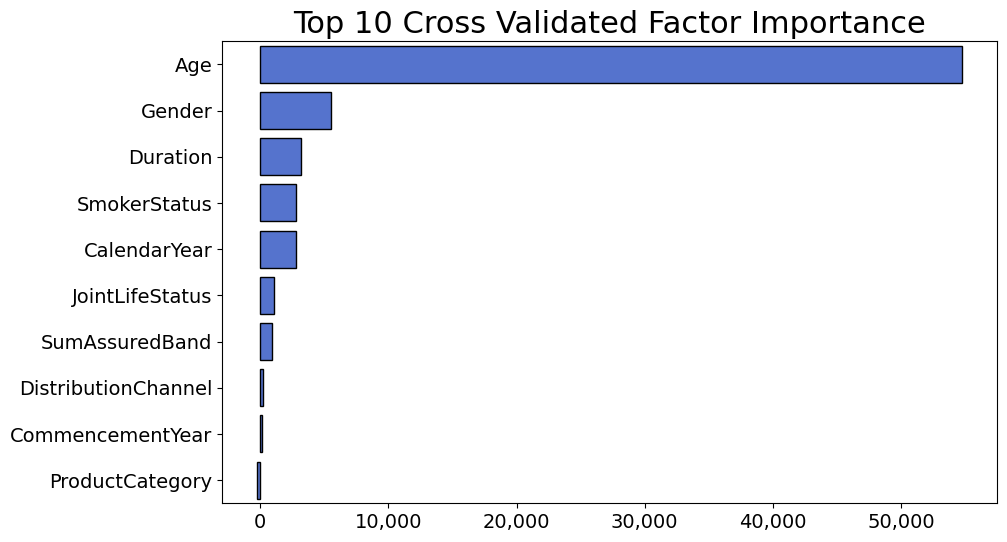

In [0]:
###########################################################################
###########################################################################

tick_fontsize = 14
label_fontsize = 18
title_fontsize = 22
n = 20

###########################################################################
###########################################################################

fact_imp_df["feature_clean"] = (
    fact_imp_df["feature"].str.replace("_cat_level", "").str.replace("_level", "")
)

plt.rcParams["figure.figsize"] = [10, 6]
fig, ax = plt.subplots(1)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25

# Plot data
sns.barplot(
    x="fact_imp",
    y="feature_clean",
    data=fact_imp_df.head(n),
    ax=ax,
    color="royalblue",
    edgecolor="black",
)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:,.0f}"))
ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
ax.set_title(
    f"Top {min(n, fact_imp_df.shape[0])} Cross Validated Factor Importance",
    fontsize=title_fontsize,
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)
ax.set_facecolor("white")

## Factor Pruning

In [0]:
retune = 2

# Initiate a dataframe to track progress during pruning
factor_prune_df = pd.DataFrame(range(fact_imp_df.shape[0]), columns=["iter"])
factor_prune_df["cv_deviance"] = np.nan
factor_prune_df["num_factors"] = np.nan

factor_prune_df.loc[0, ["cv_deviance"]] = factor_imp.baseline
factor_prune_df.loc[0, ["num_factors"]] = len(fact_imp_df)

factorlist = fact_imp_df["feature"]
numfacs = len(factorlist)

factor_prune_df[list(param_dict.keys())] = np.nan
factor_prune_df.loc[0, list(param_dict.keys())] = list(param_dict.values())

# initialise a container to track the factors dropped
factorstracking = []
factorstracking.append(factorlist.to_list())

params_prune = param_dict.copy()
lam_num = params_prune["lam_num"]
lam_cat = params_prune["lam_cat"]
n_splines = params_prune["n_splines"]

for i in range(numfacs):
    if len(factorlist) == 1:
        break

    variable_list = factorlist.to_list()
    # Number of factors to drop for each iteration
    drop_num = 1

    variable_list = variable_list[: len(factorlist) - drop_num]
    print("=" * 100)
    print(f"Iteration {i+1}: Number of features: {len(variable_list)} ")

    # Define the feature dataframe
    X_train_prune = X_train_rs[variable_list]
    # Re-define the list of numerical variables
    num_feat_prune = list(set(num_feat).intersection(set(variable_list)))
    # Re-define the list of categorical variables
    cat_feat_prune = list(set(cat_feat).intersection(set(variable_list)))
    # Define the term string for model training
    (
        term_string_prune,
        num_feat_map_prune,
        cat_feat_map_prune,
        _,
    ) = training.create_term_structure(
        num_feat_prune,
        cat_feat_prune,
        X_train_prune,
    )

    X_train_prune_cv = {}
    X_valid_prune_cv = {}

    for j, (train_idx, valid_idx) in enumerate(folds):
        X_train_prune_cv[j] = X_train_prune.iloc[train_idx]
        X_valid_prune_cv[j] = X_train_prune.iloc[valid_idx]

        for var in cat_feat_prune:
            unique_level = X_train_prune_cv[j][var].unique()
            condition = X_valid_prune_cv[j][var].isin(unique_level)
            X_valid_prune_cv[j][var] = np.where(
                condition,
                X_valid_prune_cv[j][var],
                X_train_prune_cv[j][var].mode().iloc[0],
            )

    # Periodically re-tune hyperparameters
    if i % retune == 0 and i > 0:
        n_splines_range = (
            max(params_prune["n_splines"] - 1, 4),
            params_prune["n_splines"] + 1,
        )
        lam_num_range = (
            max(params_prune["lam_num"] / 10, 1),
            params_prune["lam_num"] * 10,
            True,
        )
        lam_cat_range = (
            max(params_prune["lam_cat"] / 10, 1),
            params_prune["lam_cat"] * 10,
            True,
        )

        # create study
        study = optuna.create_study(direction="minimize")

        # define objective
        objective = training.OptunaGamObjectiveCV(
            term_string_prune,
            5,
            n_splines_range,
            lam_num_range,
            lam_cat_range,
            X_train_prune_cv,
            X_valid_prune_cv,
            y_train_cv,
            y_valid_cv,
            w_train_cv,
            w_valid_cv,
        )
        study.optimize(objective, n_trials=15)
        params_prune = study.best_params
        lam_num = params_prune["lam_num"]
        lam_cat = params_prune["lam_cat"]
        n_splines = params_prune["n_splines"]
        params_prune = {k: v for k, v in params_prune.items() if k in param_dict.keys()}

    factor_imp_prune = explain.FactorImpCV(
        term_string_prune,
        5,
        X_train_prune_cv,
        X_valid_prune_cv,
        y_train_cv,
        y_valid_cv,
        w_train_cv,
        w_valid_cv,
        **params_prune,
    )

    fact_imp_prune_df = factor_imp_prune()
    factorlist = fact_imp_prune_df["feature"]
    factorlist2 = np.full(numfacs, np.nan, dtype="object")
    factorlist2[: len(factorlist)] = factorlist
    factorstracking.append(factorlist2)

    factor_prune_df.loc[i + 1, ["cv_deviance"]] = factor_imp_prune.baseline
    factor_prune_df.loc[i + 1, ["num_factors"]] = len(factorlist)
    factor_prune_df.loc[i + 1, list(params_prune.keys())] = list(params_prune.values())
    print(
        f"Deviance Loss in iteration {i + 1}: {factor_imp_prune.baseline:.2f}", sep="; "
    )

Iteration 1: Number of features: 9 
Deviance Loss in iteration 1: 399802.24
Iteration 2: Number of features: 8 
Deviance Loss in iteration 2: 399749.76
Iteration 3: Number of features: 7 


[I 2024-10-20 11:09:43,462] A new study created in memory with name: no-name-f7d1601d-0c20-4b09-aee5-02fb7655bafc
[I 2024-10-20 11:14:46,550] Trial 0 finished with value: 193696.05459491294 and parameters: {'n_splines': 7, 'lam_num': 1.3712451244484058, 'lam_cat': 716.6788178030826, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 0 with value: 193696.05459491294.
[I 2024-10-20 11:20:45,014] Trial 1 finished with value: 193677.04670017486 and parameters: {'n_splines': 9, 'lam_num': 3.6200708115224267, 'lam_cat': 112.72815559823688, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 1 with value: 193677.04670017486.
[I 2024-10-20 11:25:49,086] Trial 2 finished with value: 193693.93948465408 and parameters: {'n_splines': 7, 'lam_num': 4.883062533633928, 'lam_cat': 571.222156837784, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 1 with value: 193677.04670017486.
[I 2024-10-20 11:30:52,727] Tria

Deviance Loss in iteration 3: 400595.73
Iteration 4: Number of features: 6 
Deviance Loss in iteration 4: 400402.67
Iteration 5: Number of features: 5 


[I 2024-10-20 12:45:57,201] A new study created in memory with name: no-name-37ccf998-9611-44ca-8cb2-1b79075fe9c1
[I 2024-10-20 12:50:09,457] Trial 0 finished with value: 194008.69835955044 and parameters: {'n_splines': 10, 'lam_num': 10.52631638559471, 'lam_cat': 70.54996819070259, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 0 with value: 194008.69835955044.
[I 2024-10-20 12:53:46,730] Trial 1 finished with value: 194003.7026172088 and parameters: {'n_splines': 8, 'lam_num': 1.3137706654542005, 'lam_cat': 72.87480302804379, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 1 with value: 194003.7026172088.
[I 2024-10-20 12:57:25,680] Trial 2 finished with value: 194003.93105725694 and parameters: {'n_splines': 8, 'lam_num': 1.6423533122765102, 'lam_cat': 44.456714002132934, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 1 with value: 194003.7026172088.
[I 2024-10-20 13:01:23,005] Trial

Deviance Loss in iteration 5: 399380.76
Iteration 6: Number of features: 4 
Deviance Loss in iteration 6: 399311.11
Iteration 7: Number of features: 3 


[I 2024-10-20 13:52:09,444] A new study created in memory with name: no-name-40db9cad-3da4-4dfe-a94e-4e591f132b7d
[I 2024-10-20 13:53:54,583] Trial 0 finished with value: 195636.13491550295 and parameters: {'n_splines': 9, 'lam_num': 13.156684213202823, 'lam_cat': 213.86899846826753, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 0 with value: 195636.13491550295.
[I 2024-10-20 13:55:32,863] Trial 1 finished with value: 195631.524518591 and parameters: {'n_splines': 8, 'lam_num': 4.401584233251312, 'lam_cat': 8.05873009177643, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 1 with value: 195631.524518591.
[I 2024-10-20 13:57:17,795] Trial 2 finished with value: 195628.65733482072 and parameters: {'n_splines': 9, 'lam_num': 1.0276596332998522, 'lam_cat': 17.169357432253616, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 2 with value: 195628.65733482072.
[I 2024-10-20 13:59:09,473] Trial 3

Deviance Loss in iteration 7: 400630.86
Iteration 8: Number of features: 2 
Deviance Loss in iteration 8: 412122.65
Iteration 9: Number of features: 1 


[I 2024-10-20 14:21:35,712] A new study created in memory with name: no-name-acab10e0-a1ed-4f30-a9e4-638af1e48451
[I 2024-10-20 14:22:37,280] Trial 0 finished with value: 201540.6218529762 and parameters: {'n_splines': 8, 'lam_num': 1.9103198982183633, 'lam_cat': 33.02296712845826, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 0 with value: 201540.6218529762.
[I 2024-10-20 14:23:45,876] Trial 1 finished with value: 201542.1106932997 and parameters: {'n_splines': 9, 'lam_num': 5.679708985529788, 'lam_cat': 12.346727316644285, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 0 with value: 201540.6218529762.
[I 2024-10-20 14:24:47,459] Trial 2 finished with value: 201540.77751140724 and parameters: {'n_splines': 8, 'lam_num': 2.3585268117152887, 'lam_cat': 36.873387859582024, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 0 with value: 201540.6218529762.
[I 2024-10-20 14:25:55,920] Trial 3

Deviance Loss in iteration 9: 412391.47


Text(0, 0.5, '')

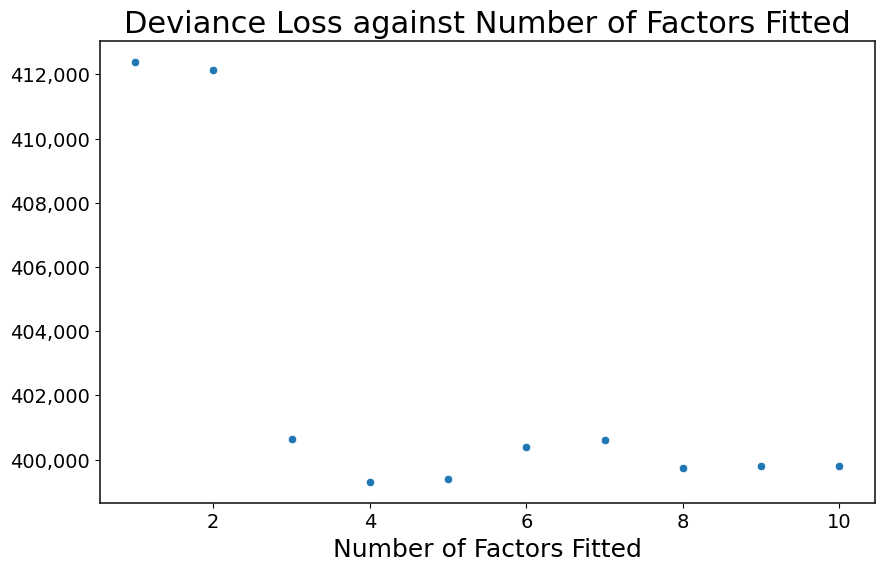

In [0]:
plt.rcParams["figure.figsize"] = [10, 6]
fig, ax = plt.subplots(1)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25

sns.scatterplot(
    data=factor_prune_df,
    x="num_factors", 
    y="cv_deviance",
    ax=ax, 
    color=["tab:blue"]
)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:,.0f}"))
ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
ax.grid(False)
ax.set_facecolor("white")

ax.set_title("Deviance Loss against Number of Factors Fitted", fontsize=title_fontsize)
ax.set_xlabel("Number of Factors Fitted", fontsize=label_fontsize)
ax.set_ylabel("")

In [0]:
factor_prune_df[(factor_prune_df["cv_deviance"] == factor_prune_df["cv_deviance"].min())]

,iter,cv_deviance,num_factors,n_splines,lam_num,lam_cat
6,6,399311.111399,4.0,9.0,1.992644,71.412727


In [0]:
# Define the iteration that min the cv score 
iter_min = factor_prune_df[(factor_prune_df["cv_deviance"] == factor_prune_df["cv_deviance"].min())].iloc[0, 0]
factorstracking_df = pd.DataFrame(factorstracking) 

# Define the final list of factors used
final_factor = factorstracking_df.iloc[iter_min][
    ~factorstracking_df.iloc[iter_min].isnull()
].to_list()

print('Minimum loss achieved with the following factors:')
print(f'Number of factors: {len(final_factor)}')
print(final_factor)

Minimum loss achieved with the following factors:
Number of factors: 4
['Age_level', 'Gender_cat_level', 'SmokerStatus_cat_level', 'Duration_level']


In [0]:
with pd.ExcelWriter(
    f"/tmp/{modelling_log}", engine="openpyxl", mode="a"
) as writer:
    factorstracking_df.to_excel(
        writer, sheet_name="Factors_Used", index=False
    )
    factor_prune_df.to_excel(writer, sheet_name="Prune_Progress", index=False)

shutil.copyfile(
    f"/tmp/{modelling_log}",
    f"{dir_output}/{modelling_log}",
)